In [1]:
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import glob
from utils import *

In [2]:
d='/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'

In [4]:
f0=d+'clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist.clm2.h1.2014-{}.nc'
files=[f0.format(str(i).zfill(2)) for i in range(1,12)]

In [6]:
ds=fix_time(xr.open_mfdataset(files,combine='by_coords'))

In [93]:
client=get_cluster(workers=20)

In [6]:
%%time


/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 35.05 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 2min 22s, sys: 3.64 s, total: 2min 26s
Wall time: 2min 37s


In [14]:
files=sorted(glob.glob('/glade/derecho/scratch/djk2120/postp/jas/TREFHTMX.*.nc'))
ds=xr.open_mfdataset(files,combine='by_coords',parallel=True)

In [33]:
cces={}
for yr in [1850,2020,2090]:
    cce=get_ds(str(yr)+'_era5_i04',['TREFHTMX'],cmp='/atm/',tape='h1')
    la=get_foco(cce)*np.cos(np.deg2rad(cce.lat))
    ixt=(cce['time.month']>=7)&(cce['time.month']<=9)
    cces[yr]=gmean(cce.TREFHTMX.isel(time=ixt).mean(dim='time'),la)

In [144]:
yr=2020
s=ds.SOILWATER_10CM.sel(year=slice(yr-10,yr+10)).stack({'ey':['ens','year']}).chunk(dict(ey=-1))
ix=s<s.quantile(0.03)

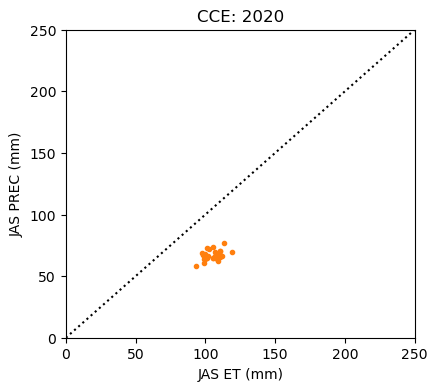

In [133]:
plt.figure(figsize=[4.5,4])
plt.plot(cf*cce.ET.sel(year=2020),
         cf*cce.PREC.sel(year=2020),'C1.',label='CCE')
plt.plot([0,250],[0,250],'k:')
plt.xlim([0,250])
plt.ylim([0,250])
plt.title('CCE: 2020')
plt.xlabel('JAS ET (mm)')
plt.ylabel('JAS PREC (mm)');
plt.savefig('../figs/cas/cce_div.png',dpi=300,bbox_inches='tight')

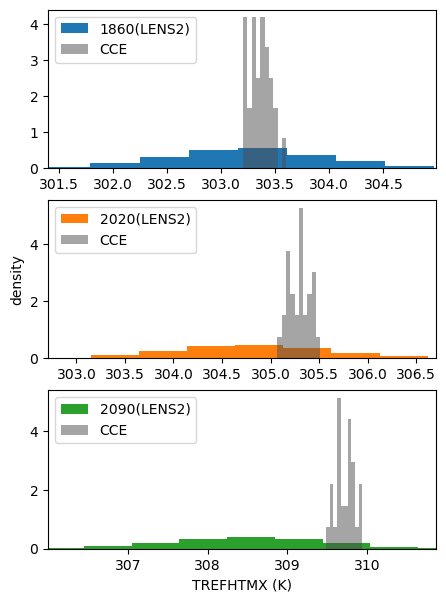

In [38]:
plt.figure(figsize=[5,7])
yrs=[1860,2020,2090]
for i,yr in enumerate(yrs):
    plt.subplot(311+i)
    if yr==1860:
        yy=1850
    else:
        yy=yr
    x=ds[None].sel(year=slice(yr-10,yr+10)).values
    c=cces[yy]

    plt.hist(x.ravel(),color='C{}'.format(i),density=True,label=str(yr)+'(LENS2)')
    plt.hist(c,density=True,color=[0.3,0.3,0.3],alpha=0.5,label='CCE')
    plt.legend(loc=2)
    plt.xlim(np.quantile(x,[0.005,0.995]))
    if i==2:
        plt.xlabel('TREFHTMX (K)')
    if i==1:
        plt.ylabel('density')
plt.savefig('../figs/hists/TREFHTMX.png',dpi=300,bbox_inches='tight')

In [52]:

yrs=[1860,2020,2090]
for i,yr in enumerate(yrs):
    if yr==1860:
        yy=1850
    else:
        yy=yr
    x=ds[None].sel(year=slice(yr-10,yr+10)).values
    c=cces[yy]
    print(int(np.round(100*(np.sort(x.ravel())<c.mean().values).sum()/len(x.ravel()))))



58
73
90


In [2]:
f='/glade/derecho/scratch/djk2120/postp/jas/cce_era5_i04.nc'
cce=xr.open_dataset(f)

In [3]:
d='/glade/derecho/scratch/djk2120/postp/jas/'
dvs=['SOILWATER_10CM','RH2M','PREC','ET']
ds=xr.Dataset()
for v in dvs:
    files=sorted(glob.glob(d+v+'*.nc'))
    ds[v]=xr.open_mfdataset(files,combine='by_coords')[v]

In [12]:
cf=24*60*60*92

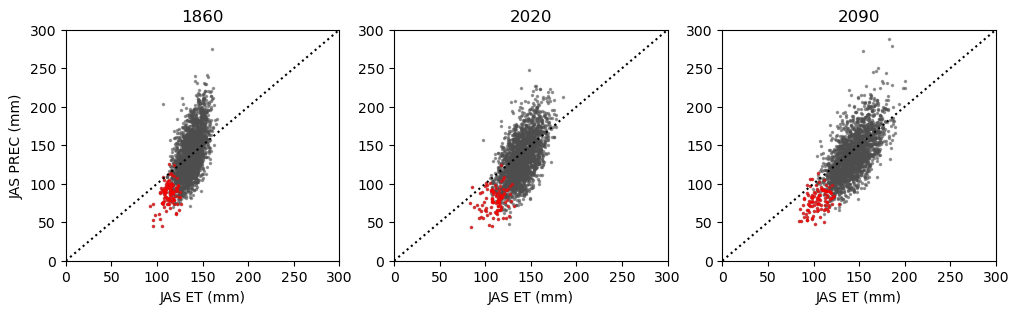

In [27]:
plt.figure(figsize=[12,3])
for i,yr in enumerate([1860,2020,2090]):
    plt.subplot(131+i)
    s=ds.SOILWATER_10CM.sel(year=slice(yr-10,yr+10)).stack({'ey':['ens','year']}).chunk(dict(ey=-1))
    ix=(s<s.quantile(0.05)).compute()
    x=cf*ds.ET.sel(year=slice(yr-10,yr+10)).stack({'ey':['ens','year']})
    y=cf*ds.PREC.sel(year=slice(yr-10,yr+10)).stack({'ey':['ens','year']})
    
    plt.plot(x,y,'.',color=[0.3,0.3,0.3],alpha=0.5,ms=3)
    plt.plot(x.isel(ey=ix),y.isel(ey=ix),'r.',alpha=0.5,ms=3)
    plt.xlim([0,300])
    plt.ylim([0,300])
    plt.plot([0,300],[0,300],'k:');
    plt.xlabel('JAS ET (mm)')
    if i==0:
        plt.ylabel('JAS PREC (mm)')
    plt.title(yr)

plt.savefig('../figs/cas/sw5_subset.png',dpi=300,bbox_inches='tight')

In [21]:
cf=24*60*60*92

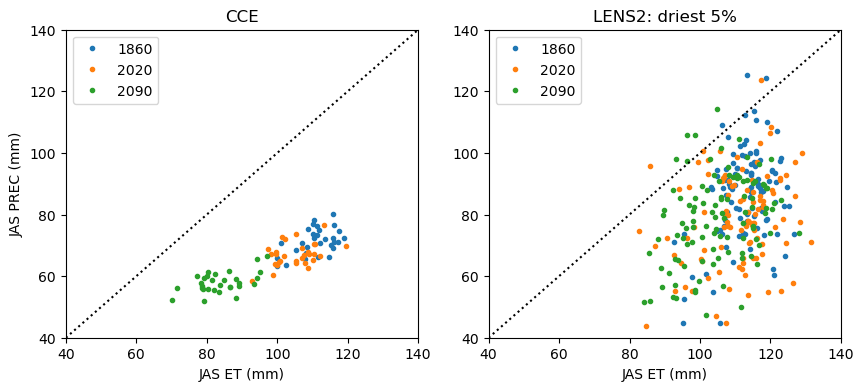

In [47]:
plt.figure(figsize=[10,4])
plt.subplot(121)
for yr in [1850,2020,2090]:
    plt.plot(cf*cce.ET.sel(year=yr),
             cf*cce.PREC.sel(year=yr),
             '.',label=yr+10*(yr==1850))
plt.legend()
plt.xlim([40,140])
plt.ylim([40,140])
plt.plot([40,140],[40,140],'k:')
plt.xlabel('JAS ET (mm)');
plt.ylabel('JAS PREC (mm)');
plt.title('CCE');

plt.subplot(122)
for yr in [1860,2020,2090]:
    s=ds.SOILWATER_10CM.sel(year=slice(yr-10,yr+10)).stack({'ey':['ens','year']}).chunk(dict(ey=-1))
    ix=(s<s.quantile(0.05)).compute()
    plt.plot(cf*ds.ET.sel(year=slice(yr-10,yr+10)).stack({'ey':['ens','year']}).isel(ey=ix),
             cf*ds.PREC.sel(year=slice(yr-10,yr+10)).stack({'ey':['ens','year']}).isel(ey=ix),
             '.',label=yr)
plt.legend()
plt.xlim([40,140])
plt.ylim([40,140])
plt.plot([40,140],[40,140],'k:')
plt.xlabel('JAS ET (mm)')
plt.title('LENS2: driest 5%');
plt.savefig('../figs/cas/scatter_et_vs_p.png',bbox_inches='tight',dpi=300)

In [59]:
ix.sum().values

array(42)

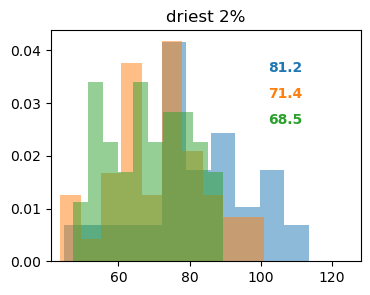

In [72]:
xs=[]
i=0
plt.figure(figsize=[4,3])
for yr in [1860,2020,2090]:
    
    s=ds.SOILWATER_10CM.sel(year=slice(yr-10,yr+10)).stack({'ey':['ens','year']}).chunk(dict(ey=-1))
    ix=(s<s.quantile(0.02)).compute()
    x=cf*ds.PREC.sel(year=slice(yr-10,yr+10)).stack({'ey':['ens','year']}).isel(ey=ix)
    xs.append(x)
    plt.hist(x,alpha=0.5,density=True)
    plt.text(102,0.036-i*0.005,np.round(x.mean().values,1),color='C'+str(i),fontweight='bold')
    i+=1
plt.xlim([41,128])
plt.xticks(range(60,140,20));
plt.title('driest 2%')
plt.savefig('../figs/cas/dry2.png',bbox_inches='tight',dpi=300)

In [55]:
stats.ttest_ind(xs[2],xs[0])

TtestResult(statistic=-3.5829838599606827, pvalue=0.0006817200263731359, df=60.0)

<xarray.DataArray 'PREC' (ey: 42)>
dask.array<mul, shape=(42,), dtype=float64, chunksize=(16,), chunktype=numpy.ndarray>
Coordinates:
  * ey        (ey) object MultiIndex
  * ens       (ey) int64 2 2 3 5 6 7 9 9 10 13 ... 73 75 75 79 80 83 84 93 98 99
  * year      (ey) int64 2021 2025 2028 2023 2020 ... 2028 2029 2013 2014 2027
    quantile  float64 0.02

In [55]:
d='/glade/derecho/scratch/djk2120/postp/jas/'
dvs=[f.split('/')[-1].split('.')[0] for f in glob.glob(d+'*1950.nc')]
ds=xr.Dataset()
for v in dvs:
    files=sorted(glob.glob(d+v+'*.nc'))
    ds[v]=xr.open_mfdataset(files,combine='by_coords',parallel=True)[v]

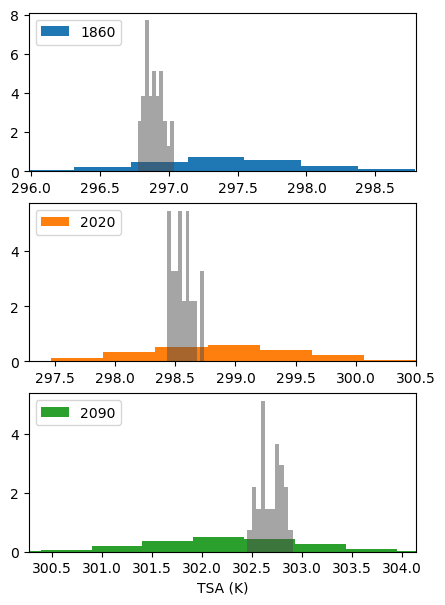

In [60]:
plt.figure(figsize=[5,7])
yrs=[1860,2020,2090]
for i,yr in enumerate(yrs):
    plt.subplot(311+i)
    if yr==1860:
        yy=1850
    else:
        yy=yr
    x=ds.TSA.sel(year=slice(yr-10,yr+10)).values
    c=cce.TSA.sel(year=yy).values

    plt.hist(x.ravel(),color='C{}'.format(i),density=True,label=yr)
    plt.legend(loc=2)
    plt.hist(c,density=True,color=[0.3,0.3,0.3],alpha=0.5)
    plt.xlim(np.quantile(x,[0.005,0.995]))
    if i==2:
        plt.xlabel('TSA (K)')
plt.savefig('../figs/hists/TSA.png',dpi=300,bbox_inches='tight')

In [59]:

yrs=[1860,2020,2090]
for i,yr in enumerate(yrs):

    if yr==1860:
        yy=1850
    else:
        yy=yr
    x=ds.TSA.sel(year=slice(yr-10,yr+10)).values
    c=cce.TSA.sel(year=yy).values
    print(int(np.round(100*(np.sort(x.ravel())<c.mean()).sum()/len(x.ravel()))))

18
31
71


In [69]:
cfs={v:1 for v in dvs}
for v in ['ET','PREC','QRUNOFF','NBP']:
    cfs[v]=24*60*60*92

In [77]:
units={v:'mm' for v in dvs}
units['VP']='kPa'

In [79]:
ixs={}
yrs=[1860,2020,2090]
for yr in yrs:
    s=ds.SOILWATER_10CM.sel(year=slice(yr-10,yr+10)).chunk(dict(year=-1))
    ix=s.stack({'ey':['ens','year']})<s.quantile(0.05)
    ixs[yr]=ix.compute()

In [75]:
cfs={'RH2M':1}
units={'RH2M':'%'}

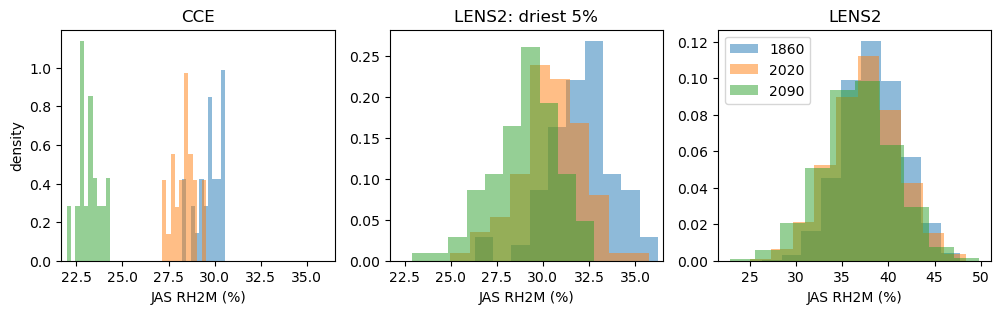

In [82]:
y=three_hists('RH2M')
plt.savefig('../figs/hists/RH2M.png',dpi=300,bbox_inches='tight')

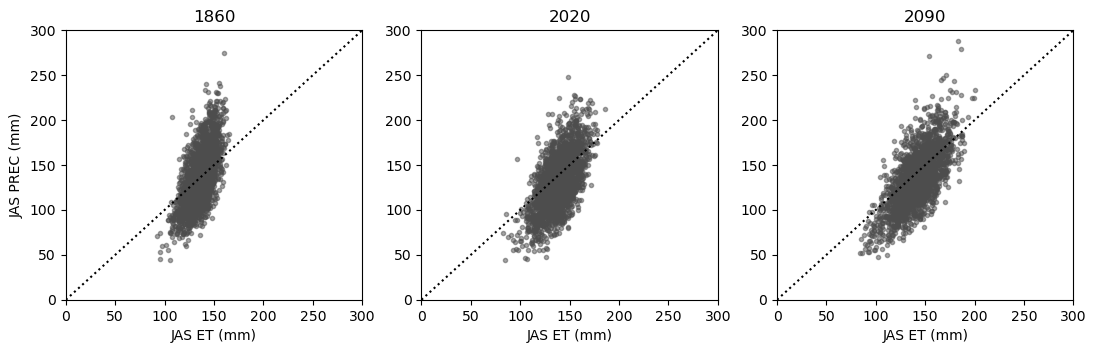

In [98]:
plt.figure(figsize=[13,3.5])
i=0
for yr in [1860,2020,2090]:
    i+=1
    plt.subplot(130+i)
    plt.plot(cf*ds.ET.sel(year=slice(yr-10,yr+10)),
             cf*ds.PREC.sel(year=slice(yr-10,yr+10)),
             '.',color=[0.3,0.3,0.3],alpha=0.5);
    plt.xlim([0,300])
    plt.ylim([0,300])
    plt.plot([0,300],[0,300],'k:')
    plt.xlabel('JAS ET (mm)')
    if i==1:
        plt.ylabel('JAS PREC (mm)')
    plt.title(yr)

plt.savefig('../figs/cas/p_vs_et_lens2.png',dpi=300,bbox_inches='tight')
        


In [77]:
def three_hists(v):
    plt.figure(figsize=[12,3])
    
    ymin,ymax=np.inf,-np.inf
    
    plt.subplot(131)
    yrs=[1850,2020,2090]
    for yr in yrs:
        y=cfs[v]*cce[v].sel(year=yr)
        ymin=min(ymin,y.min())
        ymax=max(ymax,y.max())
        plt.hist(cfs[v]*cce[v].sel(year=yr),alpha=0.5,density=True)
    plt.xlabel('JAS '+v+' ('+units[v]+')')
    plt.ylabel('density')
    plt.title('CCE')
    
    yout=[]
    plt.subplot(132)
    yrs=[1860,2020,2090]
    for yr in yrs:
        y=cfs[v]*ds[v].sel(year=slice(yr-10,yr+10)).stack({'ey':['ens','year']}).isel(ey=ixs[yr])
        yout.append(y)
        ymin=min(ymin,y.min())
        ymax=max(ymax,y.max())
        plt.hist(y,density=True,alpha=0.5)
        plt.xlabel('JAS '+v+' ('+units[v]+')')
    
    dy=ymax-ymin
    plt.xlim([ymin-0.02*dy,ymax+0.02*dy])
    plt.title('LENS2: driest 5%');
    plt.subplot(131)
    plt.xlim([ymin-0.02*dy,ymax+0.02*dy])
    
    plt.subplot(133)
    
    for yr in yrs:
        plt.hist(cfs[v]*ds[v].sel(year=slice(yr-10,yr+10)).values.ravel(),
                 label=yr,alpha=0.5,density=True)
    plt.legend(yrs)
    plt.xlabel('JAS '+v+' ('+units[v]+')')
    plt.title('LENS2');

    return yout

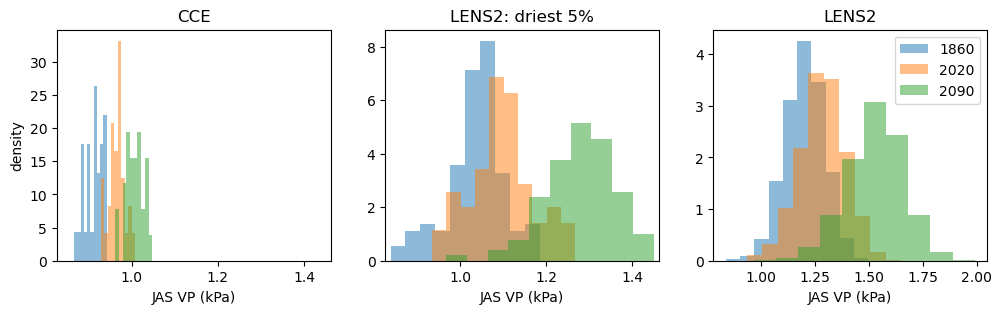

In [78]:
y=three_hists('VP')
plt.savefig('../figs/hists/VP.png',dpi=300,bbox_inches='tight')

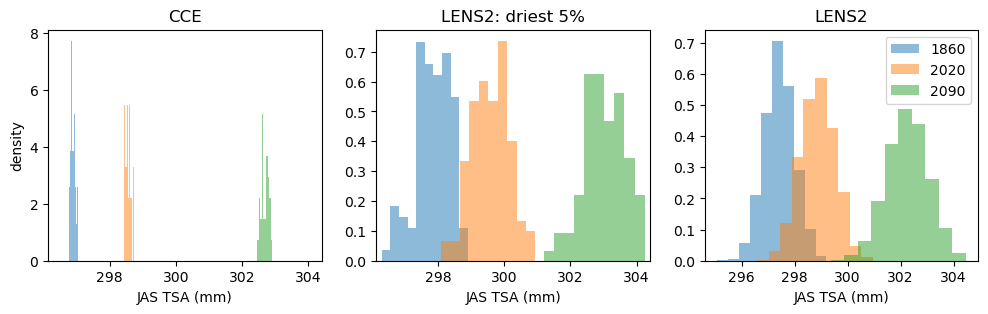

In [81]:
v='TSA'
y=three_hists(v)
plt.savefig('../figs/hists/'+v+'_colums.png',dpi=300,bbox_inches='tight')

In [87]:
ixs[yr]

<xarray.DataArray 'SOILWATER_10CM' (ey: 2100)>
array([False, False,  True, ..., False, False, False])
Coordinates:
  * ey        (ey) object MultiIndex
  * ens       (ey) int64 0 0 0 0 0 0 0 0 0 0 0 ... 99 99 99 99 99 99 99 99 99 99
  * year      (ey) int64 2010 2011 2012 2013 2014 ... 2026 2027 2028 2029 2030
    quantile  float64 0.05

In [95]:
cf=24*60*60*92

In [107]:
xs,ys=[],[]
for yr in [1860,2020,2090]:
    x=ds.SOILWATER_10CM.sel(year=slice(yr-10,yr+10)).stack({'ey':['ens','year']}).isel(ey=ixs[yr]).values
    y=cf*ds.PREC.sel(year=slice(yr-10,yr+10)).stack({'ey':['ens','year']}).isel(ey=ixs[yr]).values
    xs.append(x)
    ys.append(y)

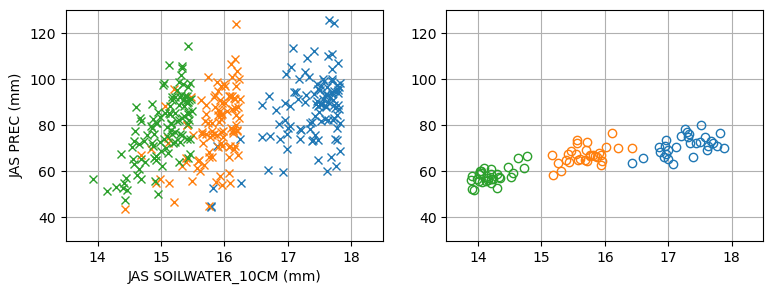

In [121]:
plt.figure(figsize=[9,3])
plt.subplot(121)
for x,y in zip(xs,ys):
    plt.plot(x,y,'x')

plt.xlim([13.5,18.5])
plt.ylim([30,130])
plt.xlabel('JAS SOILWATER_10CM (mm)')
plt.ylabel('JAS PREC (mm)')
plt.grid()
plt.subplot(122)
i=0
for x,y in zip(cce.SOILWATER_10CM,
               cf*cce.PREC):
    plt.plot(x,y,'o',color='C{}'.format(i),fillstyle='none')
    i+=1
plt.xlim([13.5,18.5])
plt.ylim([30,130])
plt.grid();

<xarray.DataArray 'SOILWATER_10CM' (year: 3)>
array([17.26561275, 15.69658938, 14.21163393])
Coordinates:
  * year     (year) int64 1850 2020 2090
    time     (year) object ...

In [131]:
cf=24*60*60*92

In [164]:
s=ds.SOILWATER_10CM.sel(year=slice(2010,2030)).stack({'ey':['ens','year']}).chunk(dict(ey=-1))
ix=(s<s.quantile(0.05)).compute()

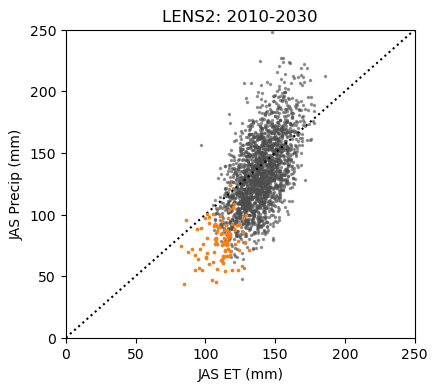

In [168]:
plt.figure(figsize=[4.5,4])
plt.plot(cf*ds.ET.sel(year=slice(2010,2030)),
         cf*ds.PREC.sel(year=slice(2010,2030)),'.',
         color=[0.3,0.3,0.3],alpha=0.5,ms=3);

plt.plot([0,250],[0,250],'k:')
plt.xlim([0,250])
plt.ylim([0,250])
plt.xlabel('JAS ET (mm)')
plt.ylabel('JAS Precip (mm)')
plt.title('LENS2: 2010-2030');
plt.savefig('../figs/cas/lens2020_p_vs_et.png',dpi=300,bbox_inches='tight')

plt.plot(cf*ds.ET.sel(year=slice(2010,2030)).stack({'ey':['ens','year']}).isel(ey=ix),
         cf*ds.PREC.sel(year=slice(2010,2030)).stack({'ey':['ens','year']}).isel(ey=ix),
         'C1.',ms=3);

plt.savefig('../figs/cas/lens2020_p_vs_et_subset.png',dpi=300,bbox_inches='tight')


In [185]:
yrs=[1860,2020,2090]
for i in range(3):
    for j in range(i+1,3):
        p1=ds.PREC.sel(year=slice(yrs[i]-10,yrs[i]+10)).values.ravel()
        p2=ds.PREC.sel(year=slice(yrs[j]-10,yrs[j]+10)).values.ravel()
        f,p=stats.ttest_ind(p1,p2)
        print(yrs[i],np.round(cf*p1.mean(),1),
              yrs[j],np.round(cf*p2.mean(),1),p)

1860 137.7 2020 131.4 4.8264909272152406e-11
1860 137.7 2090 135.1 0.007223225560951191
2020 131.4 2090 135.1 0.00011183379691521228


In [178]:
f,p=stats.ttest_ind(p1,p2)

In [179]:
p

0.00011183379691521228

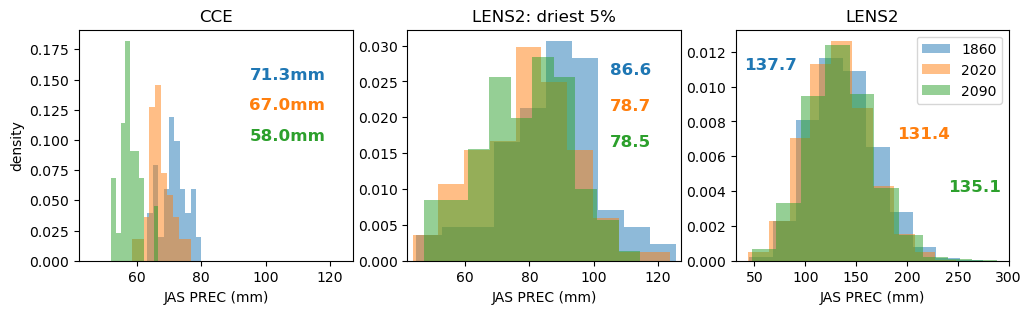

In [221]:
yy=three_hists('PREC')

yrs=[1860,2020,2090]
xs=[40,190,240]
ys=[.011,.007,.004]
plt.subplot(133)
for i in range(3):
    p=np.round(cf*ds.PREC.sel(year=slice(yrs[i]-10,yrs[i]+10)).mean().values,1)
    plt.text(xs[i],ys[i],p,color='C{}'.format(i),fontweight='bold',fontsize=12)

ys=0.026-0.005*np.arange(3)
plt.subplot(132)
for i in range(3):
    p=np.round(yy[i].mean().values,1)
    plt.text(105,ys[i],p,color='C{}'.format(i),fontweight='bold',fontsize=12)


yrs=[1850,2020,2090]
ys=[.15,.125,.1]
plt.subplot(131)
for i in range(3):
    p=np.round(cf*cce.PREC.sel(year=yrs[i]).mean().values,1)
    plt.text(95,ys[i],str(p)+'mm',color='C{}'.format(i),fontweight='bold',fontsize=12)
    
plt.savefig('../figs/hists/prec.png',dpi=300,bbox_inches='tight')

In [223]:
4.3/64.4

0.06677018633540371

In [3]:
dvs=['RAIN','SNOW','TSA','RH2M','QVEGE','QVEGT','QSOIL','SOILWATER_10CM','FSH']
yrs=['1850','2020','2090']
suffs=['_lens','_era5_i04']
exps=[yr+suff for suff in suffs for yr in yrs]

In [4]:
dsets={exp:get_ds(exp,dvs) for exp in exps}
ds=dsets[exps[0]]
la=get_foco(ds)*ds.la

In [5]:
jas={exp:{v:get_jas(dsets[exp][v],la) for v in dvs} for exp in exps}

In [8]:
for exp in exps:
    for v in ['PREC','VP']:
        jas[exp][v]=get_jas(dsets[exp][v],la)


In [22]:
for exp in exps:
    for v in ['ET']:
        jas[exp][v]=get_jas(dsets[exp][v],la)


In [35]:
ixs={}
for yr in yrs:
    sw=jas[yr+'_lens']['SOILWATER_10CM'].stack({'ey':['ens','year']})
    qq=sw.quantile(0.05)
    ix=sw<qq
    ixs[yr+'_lens']=ix

In [64]:
cvs=['PREC','ET']
suffs=['_era5_i04','_lens']

In [62]:
def three_hists(v):
    plt.figure(figsize=[12,3])
    if v in cvs: cf=24*60*60*92
    else: cf=1
    for i,suff in enumerate(suffs):
        plt.subplot(131+i)
        for yr in yrs:
            exp=yr+suff
            plt.hist(cf*jas[exp][v].values.ravel(),alpha=0.5,label=yr)
        plt.legend()
        plt.title(suff[1:])
        if 'lens' in suff:
            plt.subplot(133)
            for yr in yrs:
                exp=yr+suff
                plt.hist(cf*jas[exp][v].stack({'ey':['ens','year']}).isel(ey=ixs[exp]),alpha=0.5,label=yr)
            plt.legend()
            plt.title(suff[1:]+': driest 5%')
        

TypeError: unsupported operand type(s) for +: 'int' and 'str'

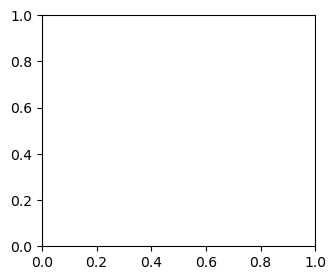

In [65]:
three_hists('PREC')

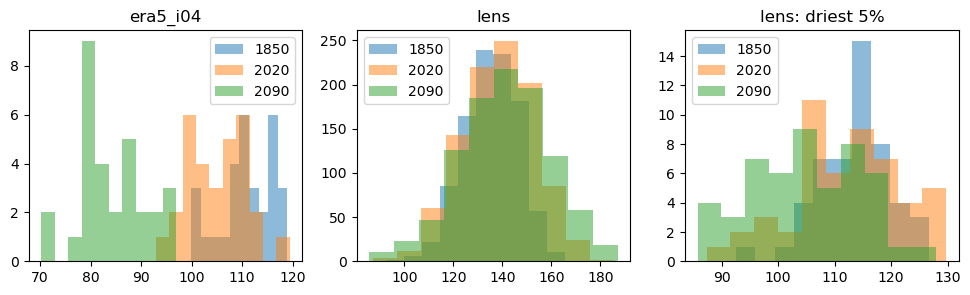

In [46]:
three_hists('ET')

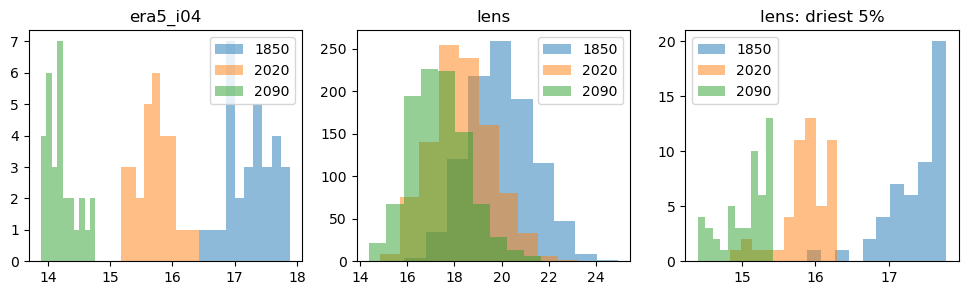

In [50]:
three_hists('SOILWATER_10CM')

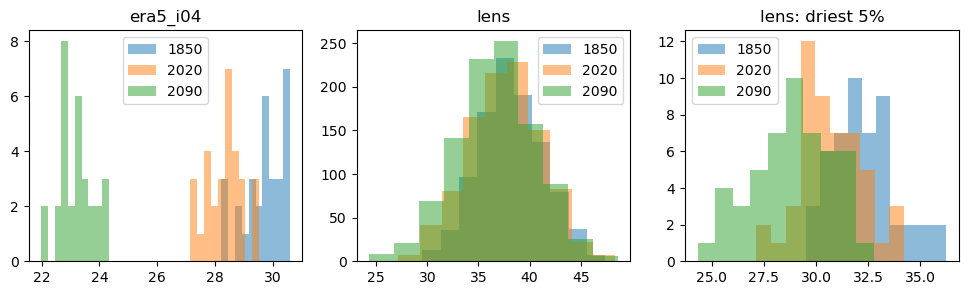

In [48]:
three_hists('RH2M')

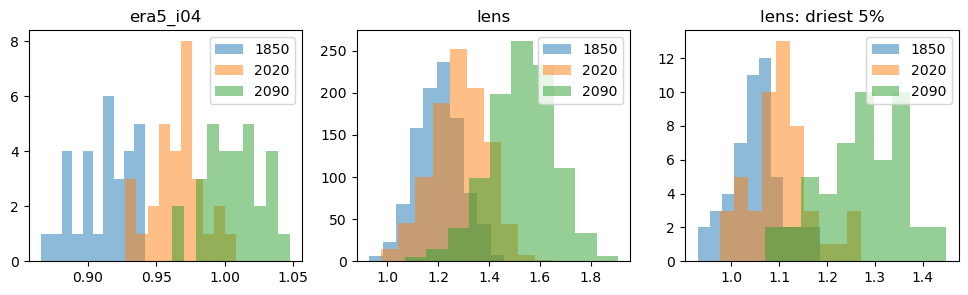

In [49]:
three_hists('VP')

In [111]:
def findlims(v,yrs=[1860,2020,2090],qq=-1):

    xmin,xmax=np.inf,-np.inf
    for yr in yrs:
        x=jas['LENS2'][yr][v].values.ravel()
        if qq>0:
            xmin=np.min([xmin,np.quantile(x,qq)])
            xmax=np.max([xmax,np.quantile(x,1-qq)])
        else:
            xmin=np.min([xmin,x.min()])
            xmax=np.max([xmax,x.max()])
        x=jas['CCE'][yr][v]        
        xmin=np.min([xmin,x.min()])
        xmax=np.max([xmax,x.max()])
        
    dx=xmax-xmin
    xmin=xmin-0.02*dx
    xmax=xmax+0.02*dx
    return xmin,xmax

In [114]:
cfs={'PREC':cf,'ET':cf,'SOILWATER_10CM':1}

In [115]:
jas={}
yrs=[1860,2020,2090]
jas['LENS2']={yr:{v:cfs[v]*ds[v].sel(year=slice(yr-10,yr+10)) for v in cfs} for yr in yrs}
yrs=[1850,2020,2090]
jas['CCE']={yr+10*(yr==1850):{v:cfs[v]*cce[v].sel(year=yr) for v in cfs} for yr in yrs}

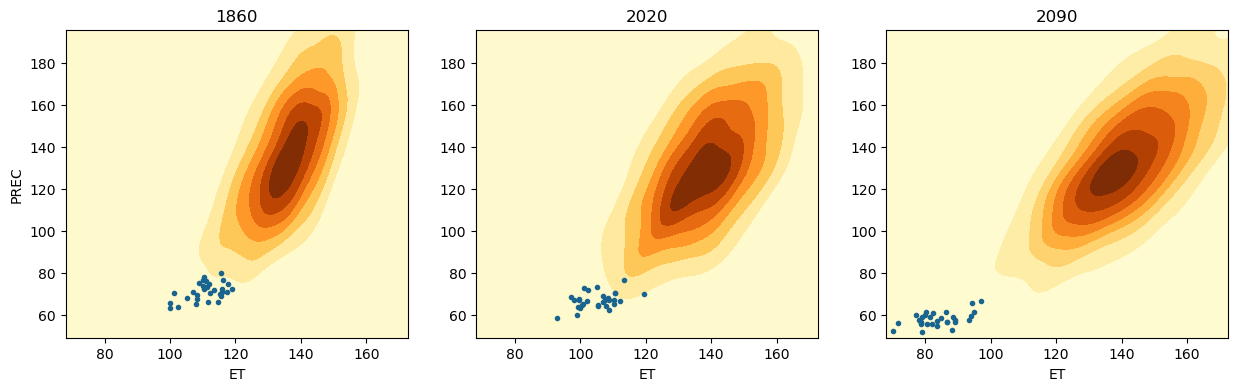

In [116]:
cplots('ET','PREC')
plt.savefig('../figs/contours/p_vs_et.png',dpi=300,bbox_inches='tight')

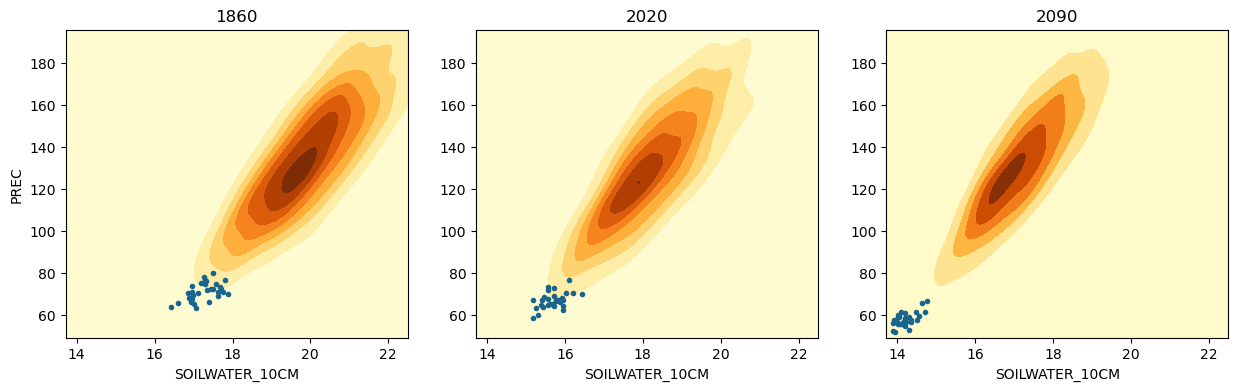

In [117]:
cplots('SOILWATER_10CM','PREC')
plt.savefig('../figs/contours/p_vs_sw.png',dpi=300,bbox_inches='tight')

In [107]:
def cplots(v1,v2):
    plt.figure(figsize=[15,4])
    for i,yr in enumerate([1860,2020,2090]):
        x=jas['LENS2'][yr][v1].values.ravel()
        y=jas['LENS2'][yr][v2].values.ravel()

        xc=jas['CCE'][yr][v1]
        yc=jas['CCE'][yr][v2]


        xmin,xmax=findlims(v1,qq=0.05)
        ymin,ymax=findlims(v2,qq=0.05)

        kernel=stats.gaussian_kde(np.array([x,y]))
        X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]  
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = np.reshape(kernel(positions).T, X.shape)


        plt.subplot(1,3,i+1)
        plt.contourf(X,Y,Z,cmap='YlOrBr')
        plt.plot(xc,yc,'.',color='#1a658fff');
        plt.xlim([xmin,xmax])
        plt.ylim([ymin,ymax])

        plt.title(yr)

        if i==0:
            plt.ylabel(v2)
        plt.xlabel(v1)
        
        #f='../figs/DTF/contours/'+v1+'_'+v2+'.png'
        #plt.savefig(f,dpi=300,bbox_inches='tight')

In [118]:
dvs=ds.data_vars
yrs=[1850,2020,2090]
jas={}
jas['CCE']={yr:{v:cfs[v]*cce[v].sel(year=yr) for v in dvs} for yr in yrs}
yrs=[1860,2020,2090]
jas['LENS2']={yr:{v:cfs[v]*ds[v].sel(year=slice(yr-10,yr+10)) for v in dvs} for yr in yrs}
jas['LENS2'][1850]=jas['LENS2'][1860]

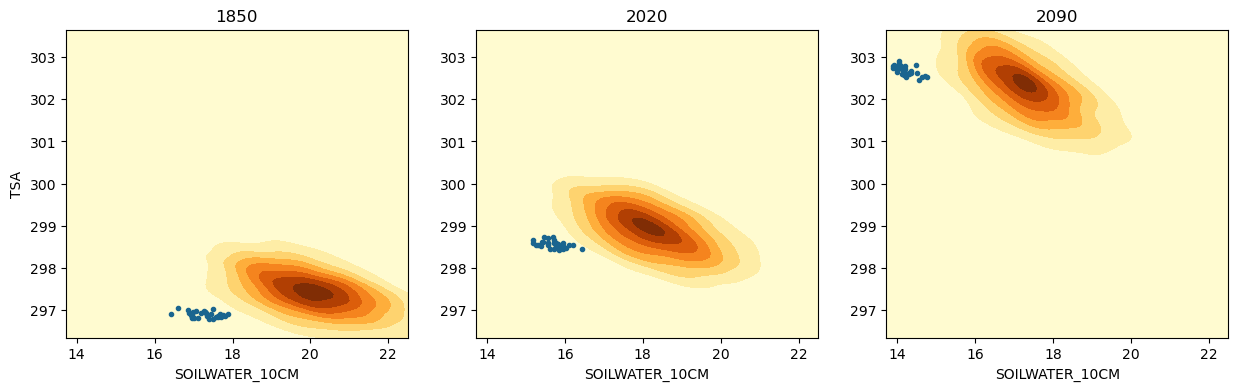

In [119]:
cplots('SOILWATER_10CM','TSA')

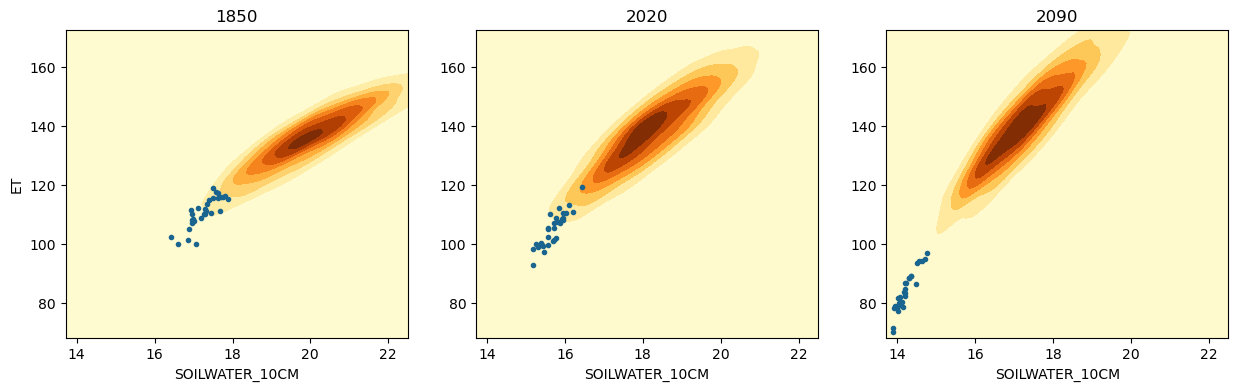

In [120]:
cplots('SOILWATER_10CM','ET')

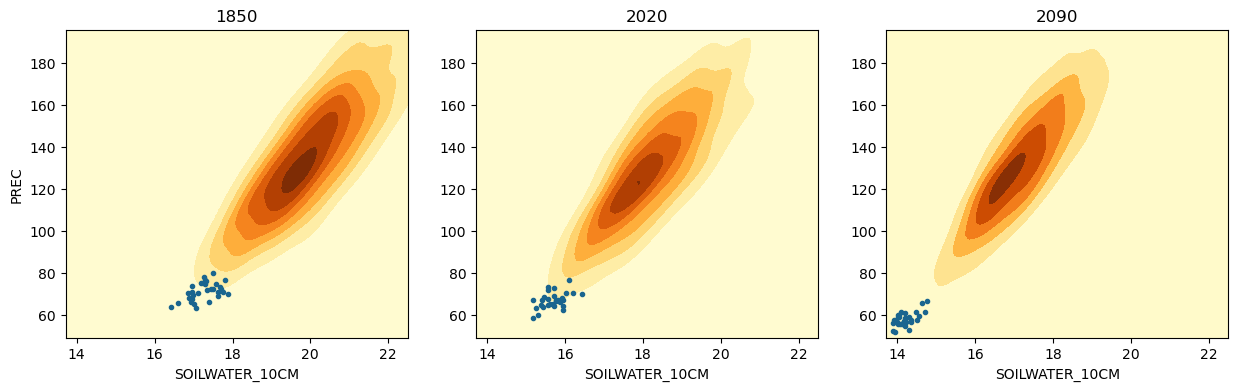

In [121]:
cplots('SOILWATER_10CM','PREC')

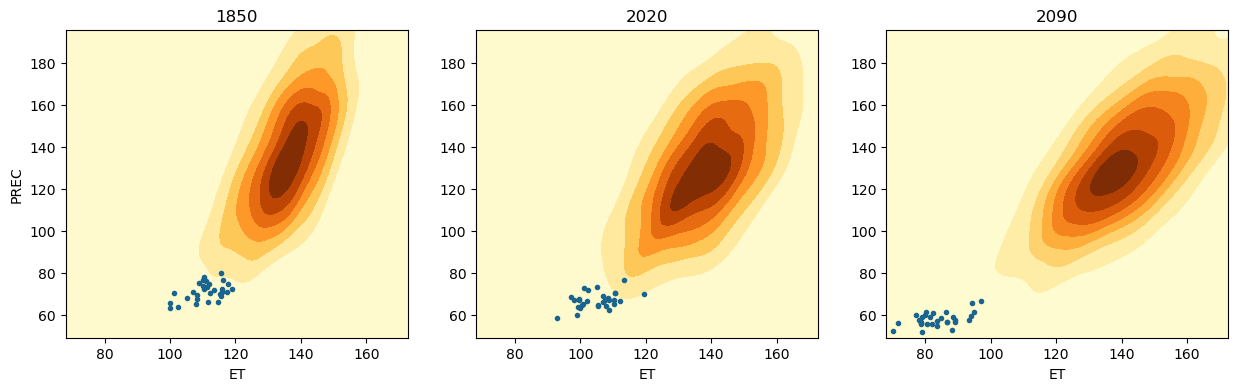

In [123]:
cplots('ET','PREC')

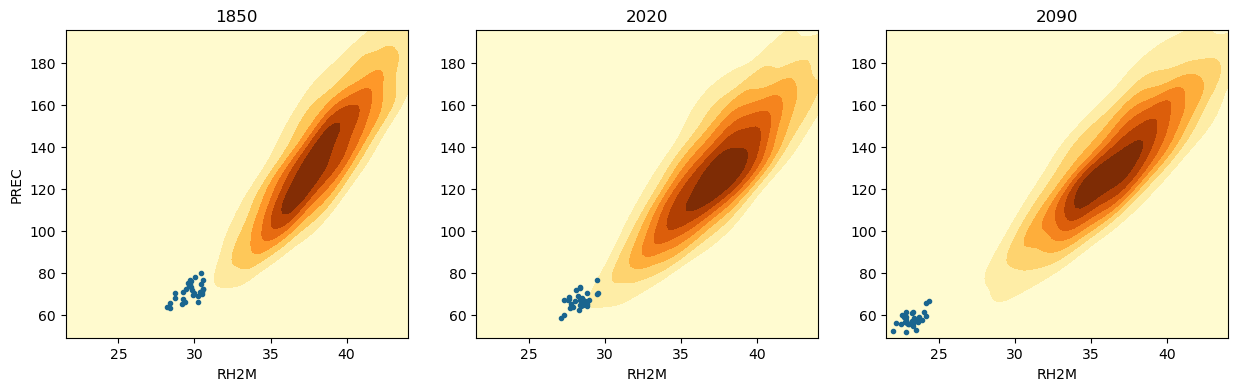

In [124]:
cplots('RH2M','PREC')